# Ejercicio 1: Análisis exploratorio de datos
_Felipe Andres Castillo_

In [1]:
#Paquetes

using Pkg
#Pkg.add("DataFrames")
#Pkg.add("Statistics")
#Pkg.add("StatsBase")
#Pkg.add("CairoMakie")

using CSV
using DataFrames
using Statistics
using StatsBase
using CairoMakie

CairoMakie.activate!()

## Funciones / código

In [2]:
#Esta función devuelve el número de filas y columnas de un DataFrame
function dataShape(data::DataFrame)
    rows = nrow(data)
    cols = ncol(data)
    return rows, cols
end

#Esta función devuelve un DataFrame que contiene el nombre de las variables de un determinado DataFrame y el tipo de datos que contiene. 
function dataType(data::DataFrame)
    types = eltype.(eachcol(data))
    cols = names(data)
    return DataFrame(Column = cols, Data_type = types)
end

#Esta función cuenta el número de registros faltantes (missing) para una determinada columna de datos
function count_missing(col_data)
    return count(ismissing, col_data)
end

#Esta función determina el porcentaje de datos faltantes dado un conjunto de datos
function dataMissingPercentage(col_data)
    return count_missing(col_data) / length(col_data) * 100
end

#Esta función elimina las columnas de un DataFrame de acuerdo a un valor umbral del porcentaje de datos faltantes
function deleteColumns(data::DataFrame, threshold)
    cols_deleted = filter(col_name -> dataMissingPercentage(data[!, col_name]) >= threshold, names(data))
    filter_data = select(data, Not(cols_deleted))
    println("Se eliminaron $(length(cols_deleted)) columnas: $(cols_deleted)")
    return filter_data
end

#Esta función elimina las filas de un DataFrame en las cuales existe un valor ausente
function deleteRows(data::DataFrame)
    return dropmissing(data)
end

#Esta función elimina los valores atípicos de un conjunto de datos usando el rango intercuartílico
function removeOutliersIQR(col_name, data::DataFrame)
    len1, = dataShape(data)
    iq = iqr(data[!,col_name])
    Q1 = quantile(data[!,col_name], 0.25)
    Q3 = quantile(data[!,col_name], 0.75)
    upper_lim = Q3 + 1.5*iq 
    lower_lim = Q1 - 1.5*iq
    filter!(col_name => x -> lower_lim < x < upper_lim, data)
    len2, = dataShape(data)
    println("Se removieron $(len1-len2) outliers de la columna $(col_name)") 
end

#Esta función crea la matriz de correlación de los datos de un DataFrame
function calculateCorrelation(data::DataFrame)
    return cor(Matrix(data))
end

#Esta función muestra gráficamente (heatmap) una matriz de correlación
function displayCorrelation(data::DataFrame)
    cor_matrix = calculateCorrelation(data)
    var_names = names(data)
    fig = Figure(size=(1000, 800))
    ax = Axis(
        fig[1,1], 
        title = "Matríz de correlación", 
        xticks = (1:length(var_names), var_names), 
        yticks = (1:length(var_names), var_names),
        xticklabelrotation = 45,
        aspect = DataAspect()
    )
    pltobj = heatmap!(cor_matrix; colorrange=(-1, 1), colormap=Reverse(:viridis))
    Colorbar(fig[1, 2], pltobj)
    colsize!(fig.layout, 1, Aspect(1, 1.0))
    #Agregar valores de la correlación en cada celda
    for i in 1:size(cor_matrix, 1)
        for j in 1:size(cor_matrix, 2)
            text!(
                ax,
                j, i,  #Coordenadas (columna, fila)
                text = string(round(cor_matrix[i, j], digits=2)),  
                align = (:center, :center), 
                fontsize = 12,               
                color = :black               
            )
        end
    end
    return fig
end

displayCorrelation (generic function with 1 method)

## Datos

El Programa de Investigaciones Cooperativas de Pesca Oceánica de California (**CalCOFI**) es una colaboración única entre el Servicio de Pesca de la NOAA, el Instituto de Oceanografía Scripps y el Departamento de Pesca y Vida Silvestre de California.

Establecido en 1949, CalCOFI surgió con el propósito de investigar los aspectos ecológicos relacionados con el colapso de la población de la sardina del Pacífico frente a la costa de California. Actualmente, su enfoque se ha ampliado hacia el estudio del entorno marino en esta región, la gestión sostenible de sus recursos vivos y el monitoreo de indicadores clave como los fenómenos de El Niño y el cambio climático.

En este reporte se presenta un análisis exploratorio de uno de los conjuntos de datos disponibles de CalCOFI: el _Bottle Database_. Este conjunto contiene datos oceanográficos (es decir, características físicas del agua de mar) obtenidos a partir de muestras recolectadas en diversas estaciones de monitoreo.

In [3]:
#Se carga el archivo de datos CSV
bottle_data = CSV.read("./../dat/bottle.csv", DataFrame);

El **análisis exploratorio de datos** se refiere al conjunto de técnicas estadísticas cuyo objetivo es explorar, describir y resumir la naturaleza de los datos y comprender las relaciones existentes entre las variables de interés, maximizando la comprensión del conjunto de datos.

Una exploración de los datos permite **identificar posibles errores** (datos incorrectamente introducidos o detectar la ausencia de valores), revelar la presencia de valores atípicos (**outliers**), comprobar la relación entre variables (**correlaciones**) y su posible redundancia o realizar un **análisis descriptivo** de los datos mediante representaciones gráficas y resúmenes de los aspectos más significativos.

En este sentido, como primer paso es importante conocer el número total de observaciones (filas) y el número de variables (columnas) del dataset, además de saber que tipos de datos son en cada caso. 

In [4]:
rows, cols = dataShape(bottle_data)
println("El DataFrame consta de $(cols) columnas y $(rows) registros")

El DataFrame consta de 74 columnas y 864863 registros


In [5]:
dataType(bottle_data)

Row,Column,Data_type
,String,Type
1,Cst_Cnt,Int64
2,Btl_Cnt,Int64
3,Sta_ID,String15
4,Depth_ID,String
5,Depthm,Int64
6,T_degC,"Union{Missing, Float64}"
7,Salnty,"Union{Missing, Float64}"
8,O2ml_L,"Union{Missing, Float64}"
9,STheta,"Union{Missing, Float64}"


## Datos ausentes (_missing values_)

Según la tabla anterior, se observa que varias columnas contienen datos faltantes (indicados como _missing_).

La presencia de valores ausentes en un conjunto de datos puede complicar tanto los análisis estadísticos como la creación de gráficos, ya que estos valores pueden sesgar los resultados o generar errores. Por ello, es crucial identificarlos y aplicar un tratamiento adecuado.

En este caso, el primer paso será eliminar las variables que presenten un porcentaje de datos ausentes superior a un umbral predefinido. El segundo paso consistirá en eliminar las filas que contengan valores ausentes en las columnas restantes.

Por ejemplo, si se decide eliminar las columnas con más del 40% de datos faltantes:

In [6]:
# Se eliminan las columnas con más del 40% de missing values, y eliminación de registros faltantes de las columnas restantes.
bottle_dataV2 = deleteColumns(bottle_data, 40)
bottle_dataV3 = deleteRows(bottle_dataV2)
rows, cols = dataShape(bottle_dataV3)
println("El nuevo DataFrame consta de $(cols) columnas y $(rows) registros")

Se eliminaron 40 columnas: ["BtlNum", "T_qual", "S_qual", "O_qual", "SThtaq", "O2Satq", "ChlorA", "Phaeop", "PO4uM", "PO4q", "SiO3uM", "SiO3qu", "NO2uM", "NO3uM", "NH3uM", "C14As1", "C14A1p", "C14As2", "C14A2p", "DarkAs", "DarkAp", "MeanAs", "MeanAp", "IncTim", "LightP", "R_SIO3", "R_PO4", "R_NO3", "R_NO2", "R_NH4", "R_CHLA", "R_PHAEO", "R_SAMP", "DIC1", "DIC2", "TA1", "TA2", "pH2", "pH1", "DIC Quality Comment"]
El nuevo DataFrame consta de 34 columnas y 305272 registros


Es importante destacar la relación inversa entre el número de columnas eliminadas y el número de registros restantes al aplicar un umbral de datos faltantes. En otras palabras, a medida que se incrementa el umbral, se eliminan menos columnas, pero se eliminan más registros, en comparación con lo que ocurre al utilizar un umbral más restrictivo.

## Descripción de las variables

Antes de proceder al análisis de datos atípicos, es fundamental comprender mejor las características de las variables. Aunque Julia clasifica algunas variables como tipo _string_, por ejemplo, Sta_ID y Depth_ID, también existen variables numéricas que no necesariamente representan datos cuantitativos, como Cst_Cnt y Btl_Cnt.

1. **Cst_Cnt** (Cast Count): Identifica a los sondeos de CalCOFI realizados hasta el momento, numerados consecutivamente.
2. **Btl_Cnt** (Bottle Count): Por cada sondeo, se toman diferentes muestras; esta columna identifica los muestreos realizados hasta el momento, numerados consecutivamente.
3. **Sta_ID** (Station ID): Identifica a la estación de donde proviene el muestreo. Cada registro consta de dos números [Line] [Station]
4. **Depth_ID**: Identifica a los sondeos realizados siguiendo la siguiente sintaxís [Century]-[Year][Month][ShipCode]-[CastType][Julian Day]-[CastTime]-[Line][Sta][Depth][Bottle]-[Rec_Ind]

Por ello, es importante diferenciar entre variables cualitativas y cuantitativas para garantizar un tratamiento adecuado. Esta distinción permitirá realizar un análisis más preciso de los outliers y establecer correlaciones de manera efectiva.

In [7]:
dataType(bottle_dataV3)

Row,Column,Data_type
,String,DataType
1,Cst_Cnt,Int64
2,Btl_Cnt,Int64
3,Sta_ID,String15
4,Depth_ID,String
5,Depthm,Int64
6,T_degC,Float64
7,Salnty,Float64
8,O2ml_L,Float64
9,STheta,Float64


La distribución del tipo de variable es: 

In [8]:
countmap(dataType(bottle_dataV3).Data_type)

Dict{DataType, Int64} with 4 entries:
  Int64    => 17
  String15 => 1
  Float64  => 15
  String   => 1

Por suerte, en la página de CalCOFI (https://calcofi.org/data/oceanographic-data/bottle-database/) se encuentra una descripción de las variables, indicando cuales son cualitativas.

In [9]:
qualitative_var = ["Cst_Cnt", "Btl_Cnt", "Sta_ID", "Depth_ID", "BtlNum", "RecInd", "T_prec", "T_qual", "S_prec", "S_qual", "P_qual", "O_qual", "SThtaq", "O2Satq", "Chlqua", "Phaqua", "PO4q", "SiO3qu", "NO2q", "NO3q", "NH3q", "C14A1p", "C14A1q", "C14A2p", "C14A2q", "DarkAp", "DarkAq", "MeanAp", "MeanAq", "DIC Quality Comment"];

## Valores atípicos (_outliers_)

Un _outlier_ es una observación que se diferencia notablemente del resto de los datos en una variable, al punto de ser considerado un valor anómalo. Estos valores pueden influir significativamente en los análisis y resultados, afectando la precisión y validez de las conclusiones. Por ello, es fundamental identificarlos y aplicar un tratamiento adecuado, ya sea para reducir su impacto en los análisis posteriores o, en algunos casos, eliminarlos del conjunto de datos.

Una forma común de identificar valores atípicos es mediante el  **rango intercuartílico** (_Interquartile Range_ o $IQR$). En estadística descriptiva, el $IQR$ se define como la diferencia entre el tercer cuartil ($Q_3$) y el primer cuartil ($Q_1$) de una distribución. Este rango se utiliza frecuentemente para construir diagramas de caja y bigote (_box plots_), herramientas visuales que muestran la variabilidad de una variable y permiten comparar distribuciones.

Se consideran valores atípicos aquellas observaciones que se encuentran fuera de los siguientes límites:
$$q < Q_1 - 1.5 \cdot IQR$$
$$q > Q_3 + 1.5 \cdot IQR$$ 

In [10]:
# Se realiza una copia del data frame sólo por si había que corregir algo, no volver a cargar todos los cambios desde el inicio
bottle_dataV4 = copy(bottle_dataV3)
# Filtro de variables cuantitativas
quantitative_var = filter(:Column => c -> !(c ∈ qualitative_var), dataType(bottle_dataV4))
for col_name in quantitative_var.Column
    removeOutliersIQR(col_name, bottle_dataV4)
end

Se removieron 23295 outliers de la columna Depthm
Se removieron 2141 outliers de la columna T_degC
Se removieron 1259 outliers de la columna Salnty
Se removieron 0 outliers de la columna O2ml_L
Se removieron 0 outliers de la columna STheta
Se removieron 0 outliers de la columna O2Sat
Se removieron 0 outliers de la columna Oxy_µmol/Kg
Se removieron 5399 outliers de la columna R_Depth
Se removieron 227 outliers de la columna R_TEMP
Se removieron 0 outliers de la columna R_POTEMP
Se removieron 340 outliers de la columna R_SALINITY
Se removieron 0 outliers de la columna R_SIGMA
Se removieron 0 outliers de la columna R_SVA
Se removieron 40 outliers de la columna R_DYNHT
Se removieron 0 outliers de la columna R_O2
Se removieron 0 outliers de la columna R_O2Sat
Se removieron 7238 outliers de la columna R_PRES


In [11]:
rows, cols = dataShape(bottle_dataV4)
println("El nuevo DataFrame consta de $(cols) columnas y $(rows) registros")

El nuevo DataFrame consta de 34 columnas y 265333 registros


In [12]:
# Descripción general de como quedan nuestros datos
describe(bottle_dataV4)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,Cst_Cnt,8861.63,71,9556.0,33073,0,Int64
2,Btl_Cnt,2.33887e5,2161,249150.0,830773,0,Int64
3,Sta_ID,,001.0 168.0,,176.7 030.0,0,String15
4,Depth_ID,,19-4904CR-HY-087-0606-04400485-0000B-3,,20-1207OS-MX-185-1506-09330280-0000B-7,0,String
5,Depthm,168.842,0,125.0,593,0,Int64
6,T_degC,11.3256,4.04,10.45,23.09,0,Float64
7,Salnty,33.8729,32.572,33.89,35.209,0,Float64
8,O2ml_L,3.36717,0.0,3.45,9.95,0,Float64
9,STheta,25.7672,22.866,25.955,27.228,0,Float64


## Análisis de correlación

La correlación determina la relación lineal entre dos o más variables, es decir, la fuerza y la dirección de una posible relación entre variables. Dicho de otra forma, si los valores de una variable tienden a subir, los de otra u otras variables, harán lo mismo si están correladas positivamente o a la inversa, si lo están negativamente. Esto no quiere decir, que una correlación entre variables indique una relación causa-efecto. 

Considerando unicamente las variables cuantitativas:

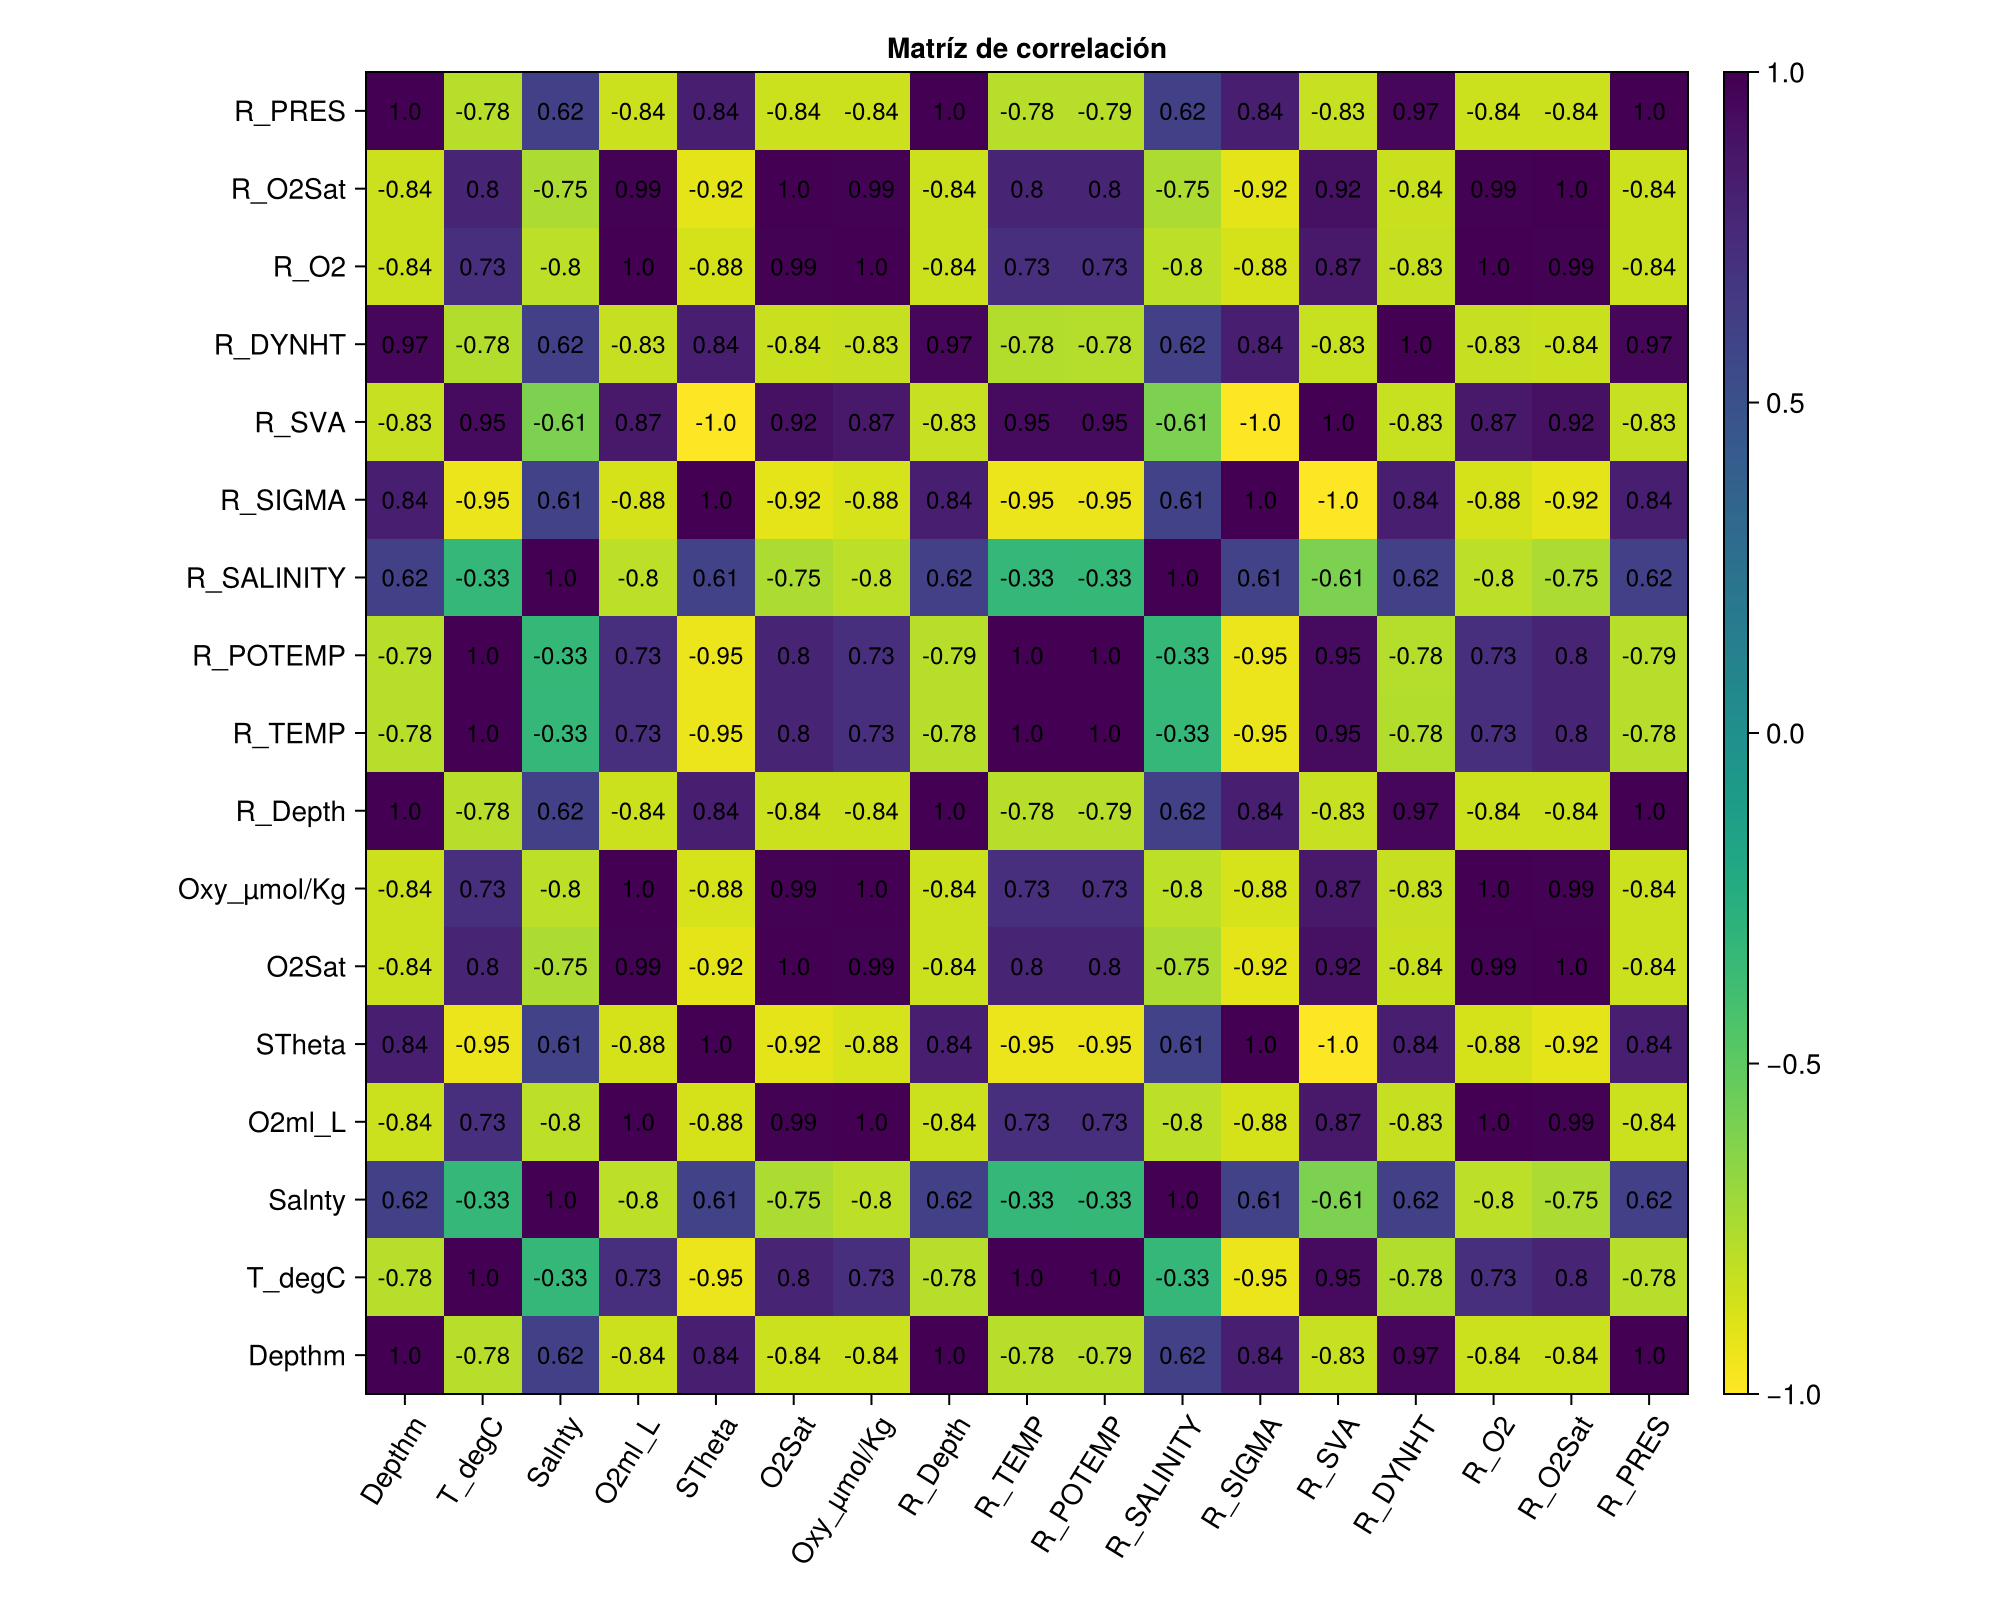

In [13]:
bottle_dataN = select(bottle_dataV4, quantitative_var.Column)
displayCorrelation(bottle_dataN)

La existencia de una relación fuerte en un determinado sentido entre dos variables podría inferir redundancia de información, pudiendo llegar a la eliminación de una de ellas con el fin de disminuir la complejidad en el procesamiento y análisis futuro de los datos. 

Por ejemplo, si consideramos a la variable T_degC, de acuerdo a la gráfica, se presenta un alto coeficiente de correlación positiva con las variables R_TEMP, R_POTEMP y R_SVA, mientras que existe un alto grado de correlación negativa con STheta y R_SIGMA.  

Dado que para la matriz de correlación y los futuros análisis de regresión solo nos interesan las variables cuantitativas, podemos extraer un subconjunto del Bottle dataset que incluya exclusivamente este tipo de variables.

Además, realizar la limpieza de datos faltantes y la detección de outliers sobre este subconjunto puede resultar en un conjunto de datos más completo. Esto se debe a que, en el conjunto original, el porcentaje de datos faltantes es significativamente mayor en las variables categóricas que en las variables numéricas.

In [14]:
#Variables cualitativas
qualitative_var = ["Cst_Cnt", "Btl_Cnt", "Sta_ID", "Depth_ID", "BtlNum", "RecInd", "T_prec", "T_qual", "S_prec", "S_qual", "P_qual", "O_qual", "SThtaq", "O2Satq", "Chlqua", "Phaqua", "PO4q", "SiO3qu", "NO2q", "NO3q", "NH3q", "C14A1p", "C14A1q", "C14A2p", "C14A2q", "DarkAp", "DarkAq", "MeanAp", "MeanAq", "DIC Quality Comment"];
#Variables cuantitativas
quantitative_var = filter(:Column => c -> !(c ∈ qualitative_var), dataType(bottle_data))
#Subconjunto del DataFrame 
bottle_varNum = select(bottle_data, quantitative_var.Column)
#Datos missing
bottle_varNum2 = deleteRows(deleteColumns(bottle_varNum, 40))
#Ourliers
bottle_varNum3 = copy(bottle_varNum2)
for col_name in names(bottle_varNum3)
    removeOutliersIQR(col_name, bottle_varNum3)
end
#Guardamos el DataFrame en formato CSV
CSV.write("./../dat/bottle2.csv", bottle_varNum3)

rows, cols = dataShape(bottle_varNum3)
println("El DataFrame final consta de $(cols) columnas y $(rows) registros")
describe(bottle_varNum3)

Se eliminaron 27 columnas: ["ChlorA", "Phaeop", "PO4uM", "SiO3uM", "NO2uM", "NO3uM", "NH3uM", "C14As1", "C14As2", "DarkAs", "MeanAs", "IncTim", "LightP", "R_SIO3", "R_PO4", "R_NO3", "R_NO2", "R_NH4", "R_CHLA", "R_PHAEO", "R_SAMP", "DIC1", "DIC2", "TA1", "TA2", "pH2", "pH1"]
Se removieron 33125 outliers de la columna Depthm
Se removieron 3015 outliers de la columna T_degC
Se removieron 2314 outliers de la columna Salnty
Se removieron 0 outliers de la columna O2ml_L
Se removieron 0 outliers de la columna STheta
Se removieron 1 outliers de la columna O2Sat
Se removieron 0 outliers de la columna Oxy_µmol/Kg
Se removieron 13454 outliers de la columna R_Depth
Se removieron 192 outliers de la columna R_TEMP
Se removieron 0 outliers de la columna R_POTEMP
Se removieron 373 outliers de la columna R_SALINITY
Se removieron 0 outliers de la columna R_SIGMA
Se removieron 0 outliers de la columna R_SVA
Se removieron 31 outliers de la columna R_DYNHT
Se removieron 0 outliers de la columna R_O2
Se rem

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,Depthm,158.221,0,110.0,558,0,Int64
2,T_degC,11.3381,3.95,10.54,23.023,0,Float64
3,Salnty,33.7749,32.464,33.772,35.102,0,Float64
4,O2ml_L,3.62925,-0.01,3.82,10.57,0,Float64
5,STheta,25.6944,22.818,25.8399,27.21,0,Float64
6,O2Sat,60.6956,-0.1,60.2,204.4,0,Float64
7,Oxy_µmol/Kg,158.098,-0.4349,166.276,461.299,0,Float64
8,R_Depth,158.221,0.0,110.0,558.0,0,Float64
9,R_TEMP,11.3382,3.95,10.54,23.02,0,Float64


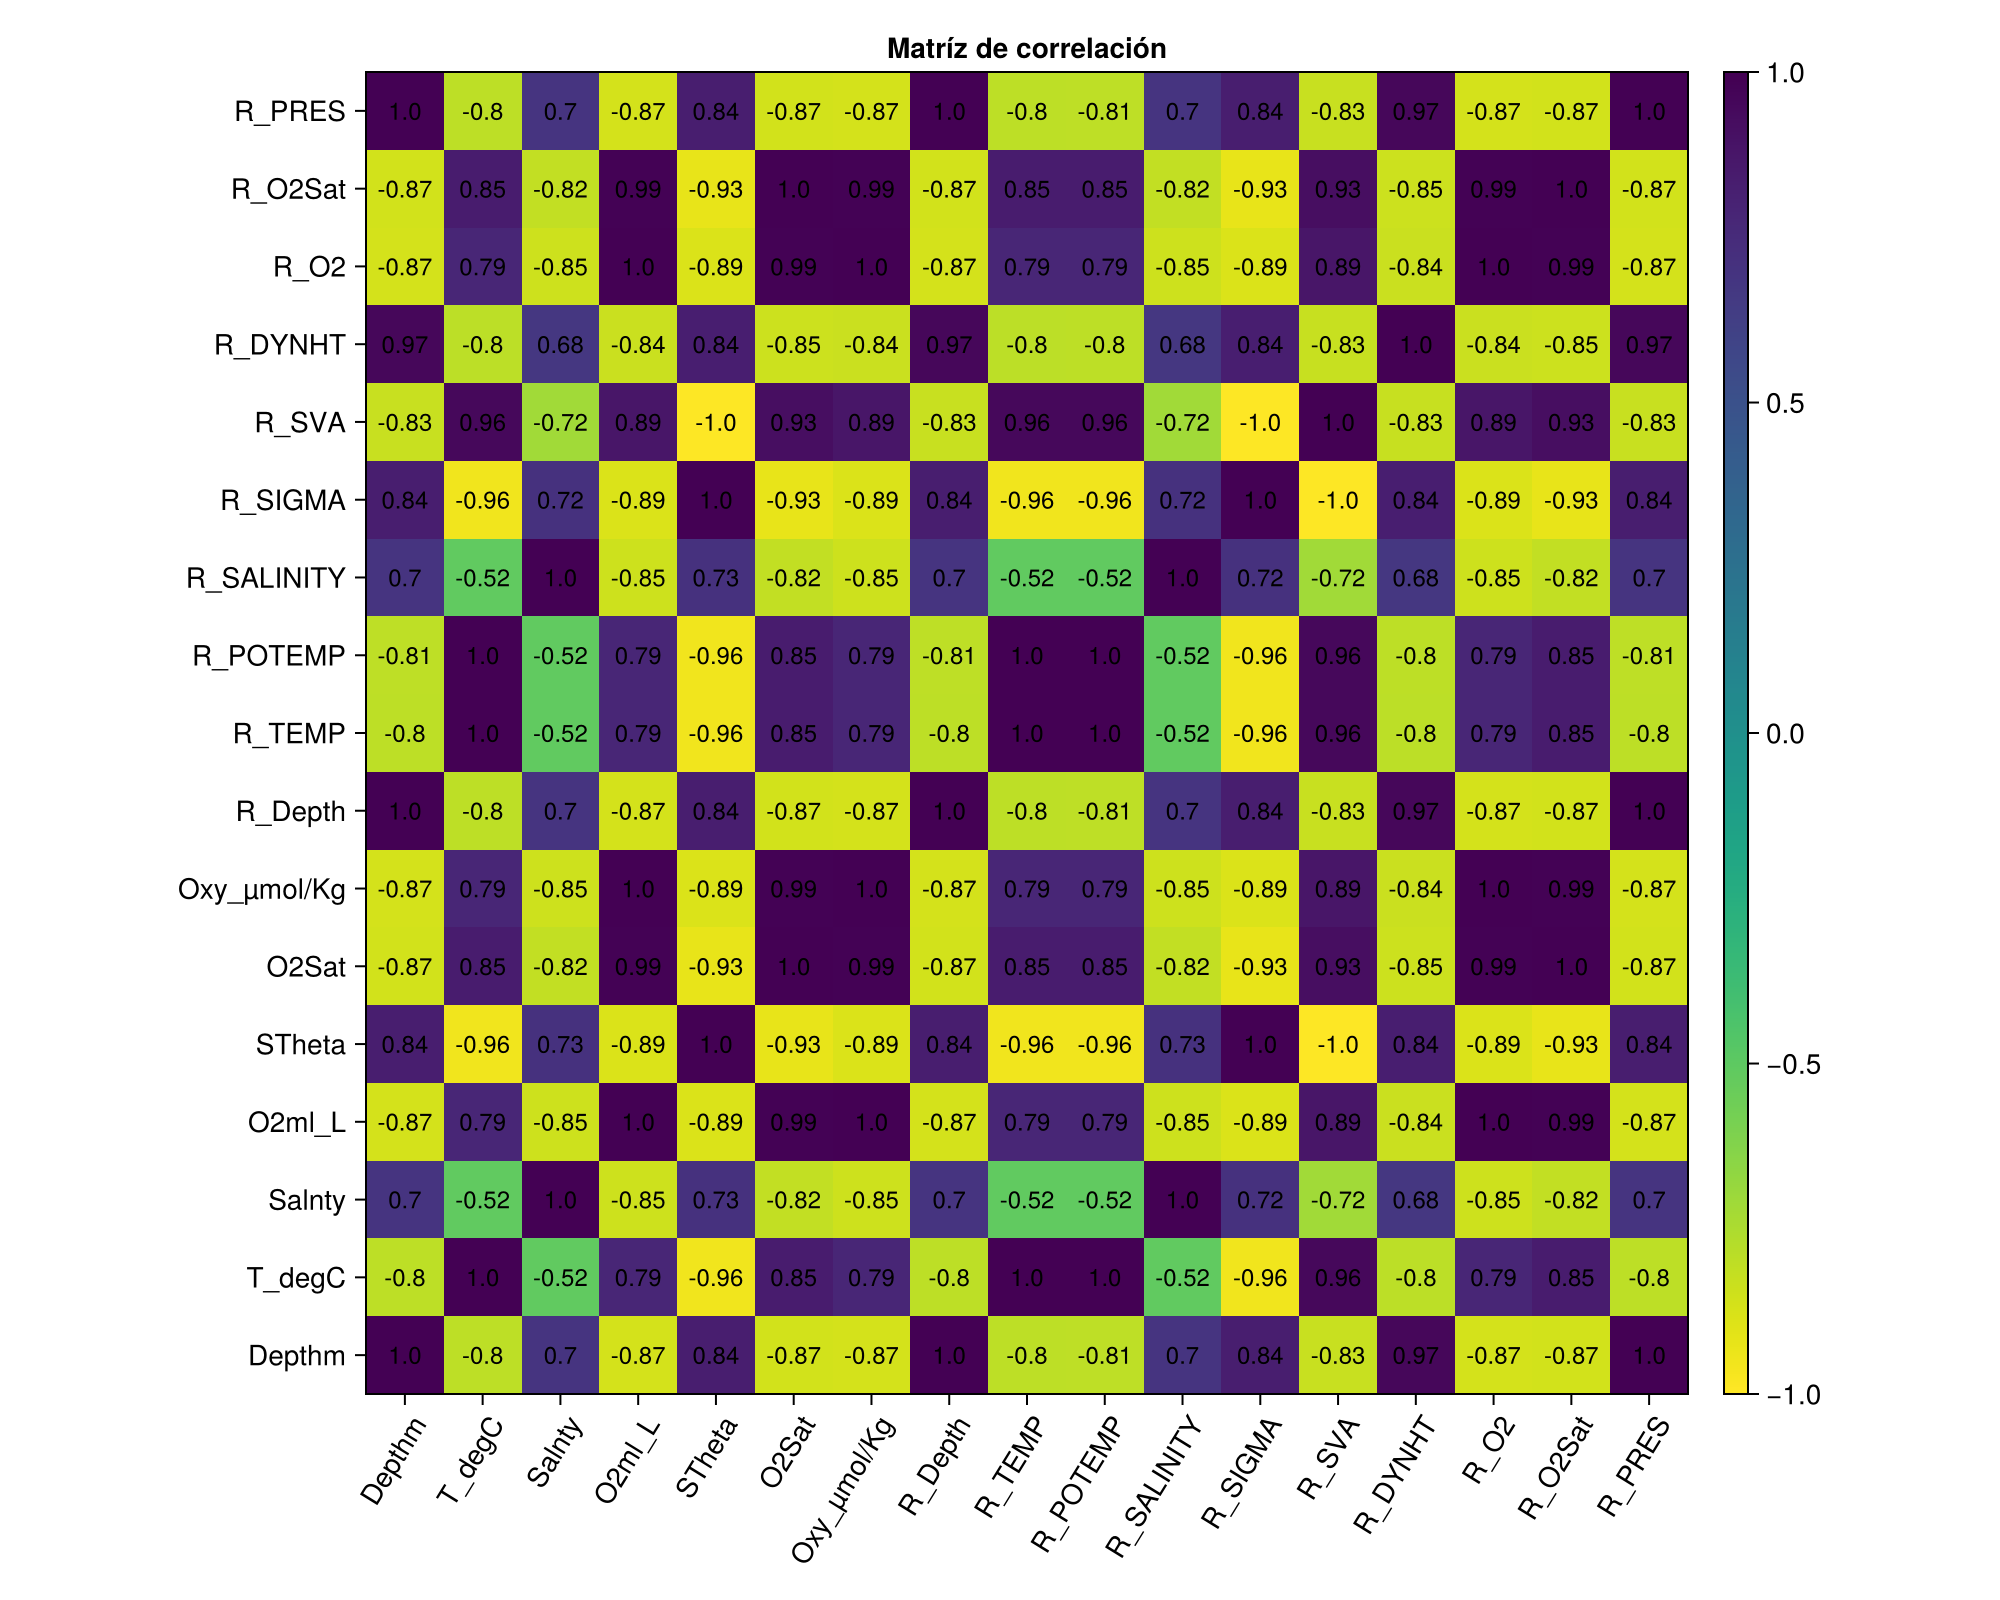

In [15]:
displayCorrelation(bottle_varNum3)

Si bien, ahora que se tienen más del doble de datos, la correlación entre las mismas variables no varía significativamente. Estos resultados nos servirán para el siguiente ejercicio. 